In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
df = pd.read_csv("CycPeptMPDB_Peptide.csv")

In [3]:
df.drop(['PAMPA', 'Caco2', 'MDCK','RRCK'], axis = 1, inplace = True)
df = df.dropna()
df.drop(['SMILES', 'Structurally_Unique_ID', 'Original_Name_in_Source_Literature', 'Year', 'Source', 'CycPeptMPDB_ID'], axis = 1, inplace = True)

In [4]:
df.drop(['Molecule_Shape','Monomer_Length_in_Main_Chain', 'Monomer_Length'], axis = 1, inplace = True)

In [5]:
df = df[df.Permeability != -10]

In [6]:
def classify_permeability(value):
    if value >= -5:
        return 'good'
    elif -7 < value < -5:
        return 'moderate/low'
    else:
        return 'impermeable'

df['Permeability_Class'] = df['Permeability'].apply(classify_permeability)

# Drop original 'Permeability_' column
df = df.drop('Permeability', axis=1)

# Encode categorical labels
label_encoder = LabelEncoder()
df['Permeability_Class'] = label_encoder.fit_transform(df['Permeability_Class'])

In [7]:
X = df.drop('Permeability_Class', axis=1)
y = df['Permeability_Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [9]:
def evaluate_model(model, X_test, y_test, deep_learning=False):
    if deep_learning:
        y_pred_prob = model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
    else:
        y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    plot_confusion_matrix(y_test, y_pred, label_encoder.classes_)
    return accuracy, f1

In [10]:
def build_deep_learning_model(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

D:\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7601 - loss: 0.6059 - val_accuracy: 0.8516 - val_loss: 0.4072
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8555 - loss: 0.3990 - val_accuracy: 0.8641 - val_loss: 0.3521
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8806 - loss: 0.3304 - val_accuracy: 0.8613 - val_loss: 0.3637
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8747 - loss: 0.3390 - val_accuracy: 0.8662 - val_loss: 0.3475
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8816 - loss: 0.3180 - val_accuracy: 0.8911 - val_loss: 0.3042
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8897 - loss: 0.2953 - val_accuracy: 0.8890 - val_loss: 0.3159
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8874 - loss: 0.2993 - val_accuracy: 0.8883 - val_loss: 0.3065
Epoch 8/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8875 - loss: 0.2958 - val_accuracy: 0.

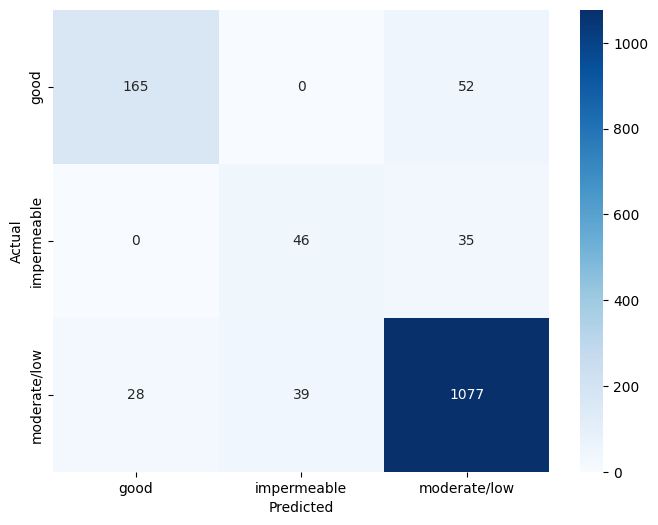

In [11]:
deep_learning_model = build_deep_learning_model(X_train.shape[1])
deep_learning_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
dl_accuracy, dl_f1 = evaluate_model(deep_learning_model, X_test, y_test, deep_learning=True)

Accuracy: 0.8932038834951457
F1 Score: 0.8864498986103653
Classification Report:
               precision    recall  f1-score   support

        good       0.87      0.70      0.78       217
 impermeable       0.63      0.41      0.50        81
moderate/low       0.91      0.96      0.93      1144

    accuracy                           0.89      1442
   macro avg       0.81      0.69      0.74      1442
weighted avg       0.89      0.89      0.89      1442



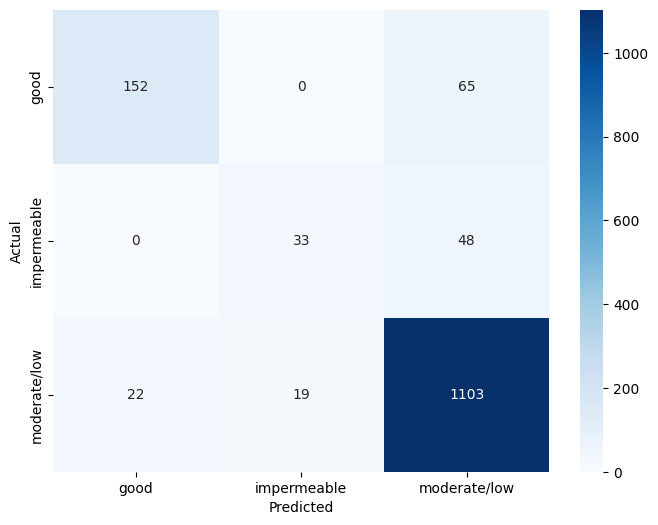

In [12]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_accuracy, rf_f1 = evaluate_model(rf_model, X_test, y_test)

Accuracy: 0.8938973647711512
F1 Score: 0.888989039823652
Classification Report:
               precision    recall  f1-score   support

        good       0.87      0.72      0.79       217
 impermeable       0.60      0.44      0.51        81
moderate/low       0.91      0.96      0.93      1144

    accuracy                           0.89      1442
   macro avg       0.79      0.71      0.74      1442
weighted avg       0.89      0.89      0.89      1442



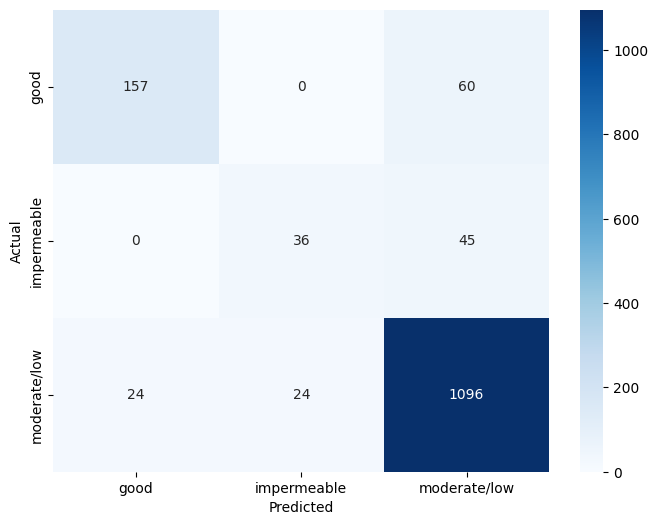

In [13]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_accuracy, xgb_f1 = evaluate_model(xgb_model, X_test, y_test)

Accuracy: 0.8564493758668515
F1 Score: 0.8328655596979646
Classification Report:
               precision    recall  f1-score   support

        good       0.75      0.59      0.66       217
 impermeable       0.60      0.07      0.13        81
moderate/low       0.87      0.96      0.92      1144

    accuracy                           0.86      1442
   macro avg       0.74      0.54      0.57      1442
weighted avg       0.84      0.86      0.83      1442



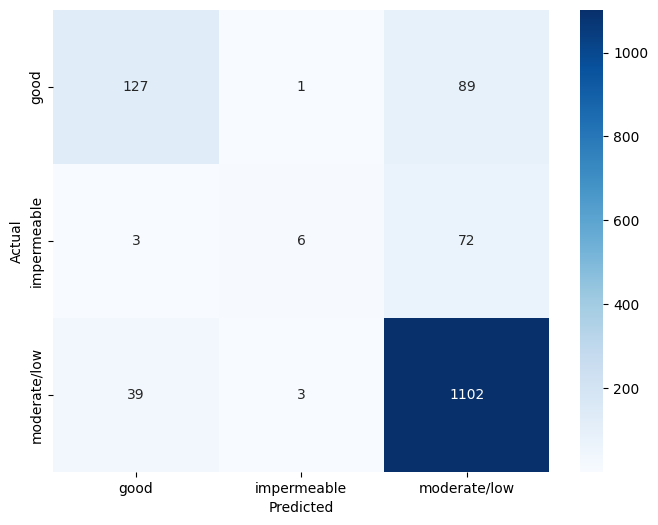

In [14]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_accuracy, svm_f1 = evaluate_model(svm_model, X_test, y_test)

Accuracy: 0.8814147018030514
F1 Score: 0.8794513672557563
Classification Report:
               precision    recall  f1-score   support

        good       0.78      0.75      0.76       217
 impermeable       0.56      0.48      0.52        81
moderate/low       0.92      0.93      0.93      1144

    accuracy                           0.88      1442
   macro avg       0.75      0.72      0.74      1442
weighted avg       0.88      0.88      0.88      1442



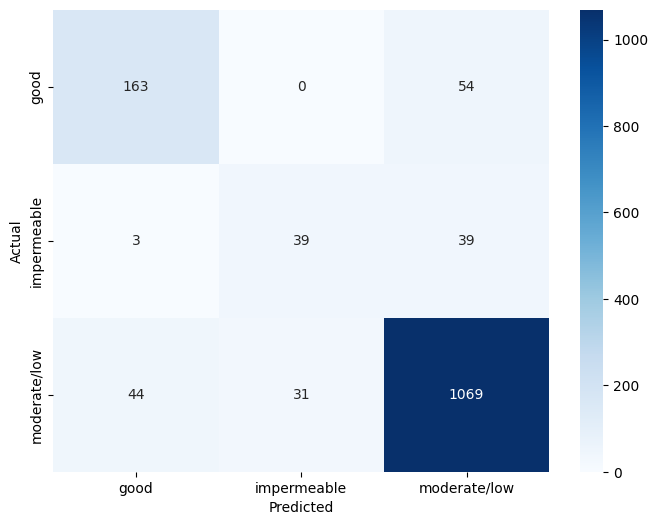

In [15]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_accuracy, dt_f1 = evaluate_model(dt_model, X_test, y_test)

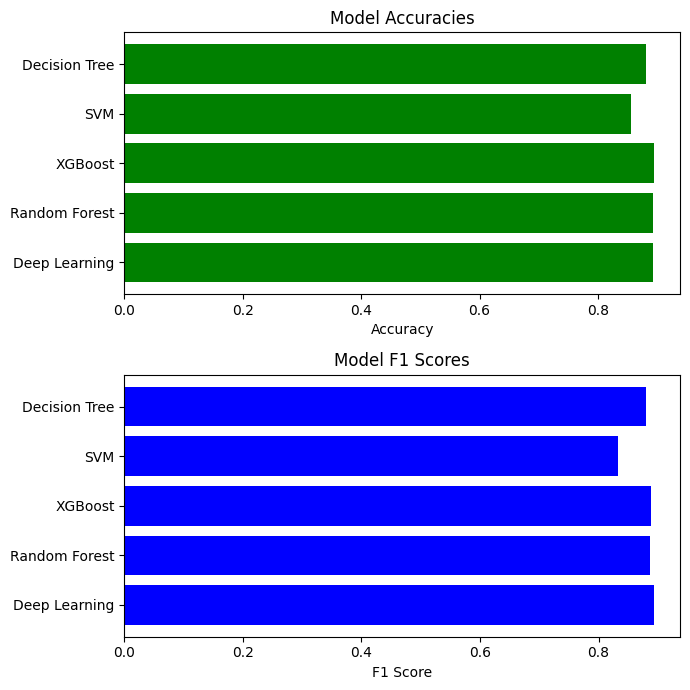

In [16]:
model_names = ['Deep Learning', 'Random Forest', 'XGBoost', 'SVM', 'Decision Tree']
accuracies = [dl_accuracy, rf_accuracy, xgb_accuracy, svm_accuracy, dt_accuracy]
f1_scores = [dl_f1, rf_f1, xgb_f1, svm_f1, dt_f1]

fig, ax = plt.subplots(2, 1, figsize=(7, 7))
ax[0].barh(model_names, accuracies, color='green')
ax[0].set_title('Model Accuracies')
ax[0].set_xlabel('Accuracy')

ax[1].barh(model_names, f1_scores, color='blue')
ax[1].set_title('Model F1 Scores')
ax[1].set_xlabel('F1 Score')

plt.tight_layout()
plt.show()